# Assignment06
- 차량 번호판 실습

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np 
import pytesseract
from  PIL import Image
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\Jay\AppData\Local\Tesseract-OCR\tesseract.exe'

이미지 크기 : (345, 558, 3)


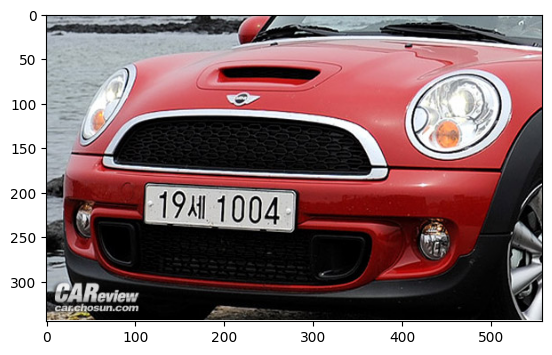

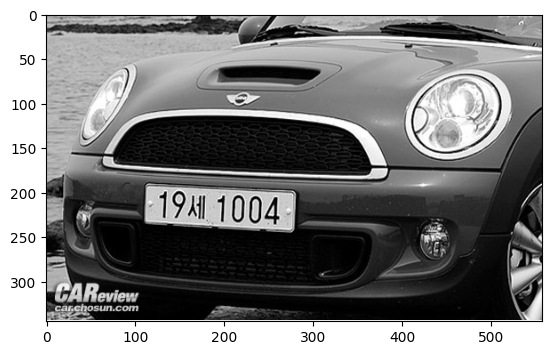

In [2]:
image_path = "./data/car5.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

h_, w_, c = image.shape
print(f"이미지 크기 : ({h_}, {w_}, {c})")

plt.imshow(image)
plt.show()

gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plt.imshow(gray_image, 'gray')
plt.show()

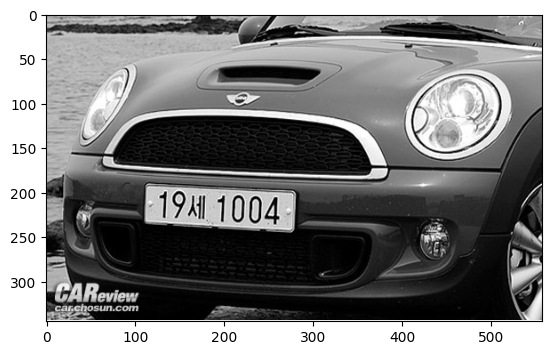

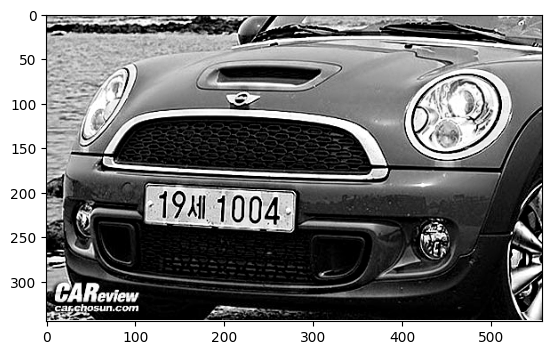

In [3]:
structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT ,(9,9))
imgTopHat = cv2.morphologyEx(gray_image, cv2.MORPH_TOPHAT, structuringElement)
imgBlackHat = cv2.morphologyEx(gray_image, cv2.MORPH_BLACKHAT, structuringElement)
imgGraysclePlusToHat = cv2.add(gray_image, imgTopHat)

plt.imshow(gray_image, 'gray')
plt.show()

gray = cv2.subtract(imgGraysclePlusToHat, imgBlackHat)
plt.imshow(gray, 'gray')
plt.show()

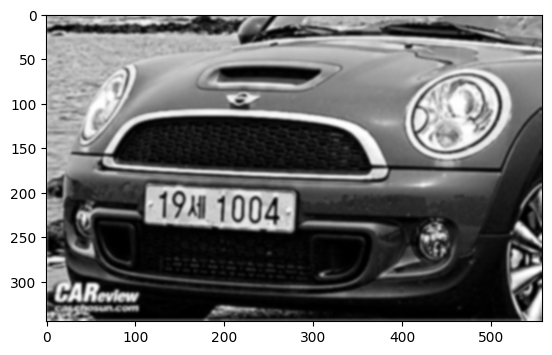

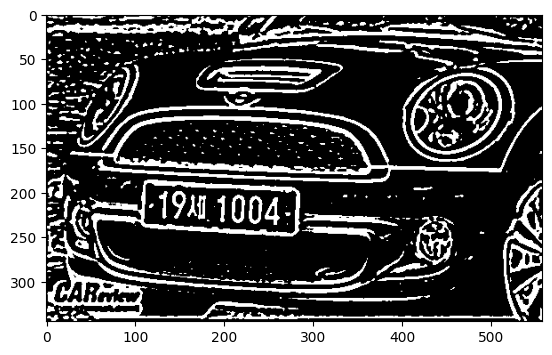

In [4]:
img_blurred = cv2.GaussianBlur(gray, ksize=(7,7), sigmaX=0)

plt.imshow(img_blurred , 'gray')
plt.show()

img_thresh  = cv2.adaptiveThreshold(
        img_blurred,
        maxValue = 255.0,
        adaptiveMethod = cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        thresholdType = cv2.THRESH_BINARY_INV,
        blockSize = 15,
        C = 9
)

plt.imshow(img_thresh , 'gray')
plt.show()

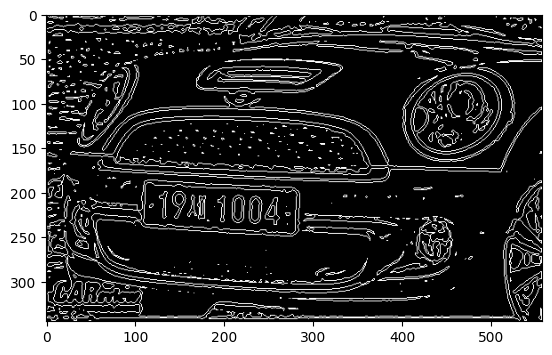

In [5]:
contours, hierarchy = cv2.findContours(
    img_thresh,
    mode = cv2.RETR_LIST,
    method = cv2.CHAIN_APPROX_SIMPLE
)

temp_result = np.zeros((h_, w_, c), dtype=np.uint8)

cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255,255,255))
plt.imshow(temp_result , 'gray')
plt.show()

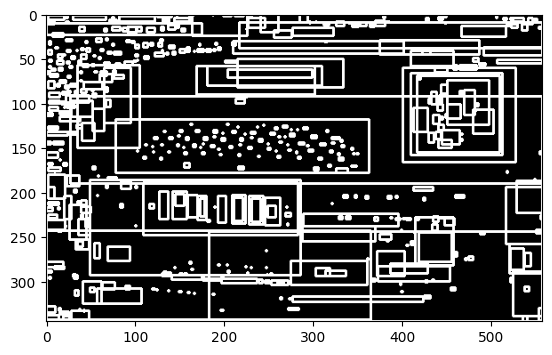

In [6]:
temp_result = np.zeros((h_, w_, c), dtype=np.uint8)   

contours_dict = []

for contour in contours : 
    x, y , w , h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result, (x,y), (x+w, y+h), (255,255,255), thickness=2)
    
    
    # inser to dict 
    contours_dict.append({
        'contour' : contour,
        'x' : x,
        'y' : y,
        'w' : w,
        'h' : h,
        'cx' : x + (w/2),
        'cy' : y + (h/2)
    })
    
plt.imshow(temp_result , 'gray')
plt.show()

3 8 3


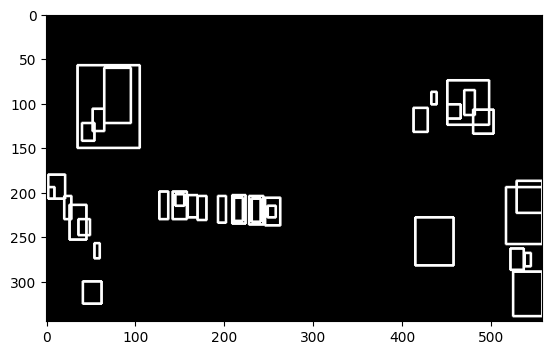

In [7]:
MIN_AREA = 80
MIN_WIDTH, MIN_HEIGHT = 2, 8
MIN_RATIO, MAX_RATIO = 0.25, 1.0

possible_contours = []

count = 0
for d in contours_dict : 
    area = d['w'] * d['h']
    ration = d['w'] / d['h']
    
    if area > MIN_AREA and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT and MAX_RATIO > ration > MIN_RATIO :
        d['idx'] = count
        count +=1
        possible_contours.append(d)

print(h, w, c)
temp_result = np.zeros((h_, w_, c), dtype=np.uint8)   


for d in possible_contours:
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), 
                  thickness=2)

plt.imshow(temp_result, 'gray')
plt.show()  

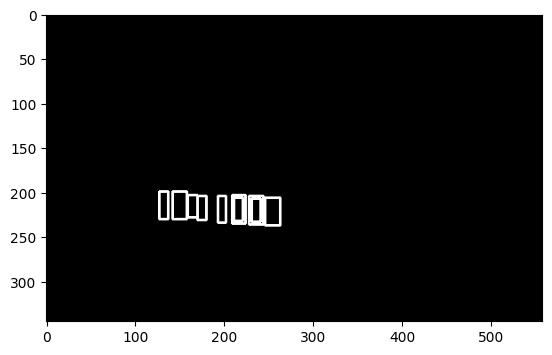

In [8]:
MAX_DIAG_MULTIPLYER = 5
MAX_ANGLE_DIFF = 12.0
MAX_AREA_DIFF = 0.5
MAX_WIDTH_DIFF = 0.8
MAX_HEIGHT_DIFF = 0.2
MIN_N_MATCHED = 4

def find_chars(contour_list) : 
    
    matched_result_idx = []
    for d1 in contour_list : 
        matched_contour_idx = []
        for d2 in contour_list : 
            if d1['idx'] == d2['idx'] : 
                continue
            
            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])
            
            diagonal_lenghtl = np.sqrt(d1['w'] **2 + d2['h'] **2)
            
            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            
            if dx == 0 :
                angle_diff = 90
            else : 
                angle_diff = np.degrees(np.arctan(dy / dx))
                
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']
            
            if distance < diagonal_lenghtl * MAX_DIAG_MULTIPLYER and angle_diff < MAX_ANGLE_DIFF \
            and area_diff < MAX_AREA_DIFF and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF : 
                matched_contour_idx.append(d2['idx'])
                
        
        matched_contour_idx.append(d1['idx'])
        
        
        if len(matched_contour_idx) < MIN_N_MATCHED : 
            continue
            
        matched_result_idx.append(matched_contour_idx)
        
        unmatched_contour_idx = []
        
        for d4 in contour_list : 
            if d4['idx'] not in matched_contour_idx :
                unmatched_contour_idx.append(d4['idx'])
                
        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
        recursive_contour_list = find_chars(unmatched_contour)
        
        for idx in recursive_contour_list :
            matched_result_idx.append(idx)
            
        break
        
    return matched_result_idx
    
result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx :
    matched_result.append(np.take(possible_contours, idx_list))
    
temp_result = np.zeros((h_, w_, c), dtype=np.uint8)   

for r in matched_result : 
    for d in  r :
        x1_temp = d['x']
        y1_temp = d['y']
        w1_temp = d['w']
        h1_temp = d['h']
        cv2.rectangle(temp_result, (x1_temp,y1_temp), (x1_temp+w1_temp, y1_temp+h1_temp), (255,255,255), thickness=2)
        
plt.imshow(temp_result, 'gray')
plt.show()  

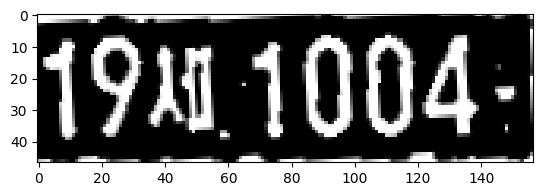

In [9]:
PLATE_WIDTH_PADDING = 1.3
PLATE_HEIGHT_PADDING = 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10 

plate_img = []
plate_infos = []

for i, matched_chars in enumerate(matched_result) : 
    sorted_chars =  sorted(matched_chars, key=lambda x : x['cx'])
    
    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2
     
    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
    
    sum_height = 0 
    for d in sorted_chars : 
        sum_height += d['h']
        
    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
    
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenus = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )
    
    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))

    rotation_matrix = cv2.getRotationMatrix2D(center = (plate_cx, plate_cy), angle=angle, scale=1.0)

    img_rotated = cv2.warpAffine(img_thresh, M=rotation_matrix, dsize=(w_, h_))

    img_cropped = cv2.getRectSubPix(
        img_rotated,
        patchSize=(int(plate_width), int(plate_height)),
        center = (int(plate_cx), int(plate_cy))
    )
    
    plate_img.append(img_cropped)
    plate_infos.append({
        'x' : int(plate_cx - plate_width / 2),
        'y' : int(plate_cy - plate_height / 2),
        'w' : int(plate_width),
        'h' : int(plate_height)
    })

plt.imshow(img_cropped, 'gray')
plt.show()

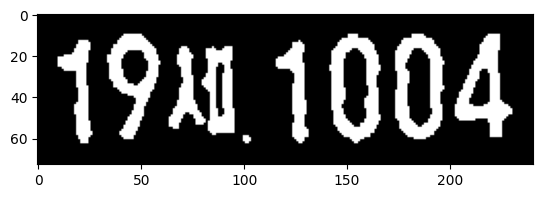

1940, 1004



In [10]:
longest_idx, longest_text = -1, 0 
plate_chars = []

for i, plate_imgs in enumerate(plate_img) :
    
    plate_imgs = cv2.resize(plate_imgs, dsize=(0,0), fx=1.6, fy=1.6)
    _, plate_imgs = cv2.threshold(plate_imgs, thresh=0.0, maxval = 255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    contours, hierarchy = cv2.findContours(plate_imgs, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
    
    plate_min_x, plate_min_y = plate_imgs.shape[1], plate_imgs.shape[0]
    plate_max_x, plate_max_y = 0, 0
    
    
    for contour in contours : 
        contour_x, contour_y, contour_w, contour_h = cv2.boundingRect(contour)
        
        area_temp = contour_w * contour_h
        ratio_temp  = contour_w / contour_h
                
        if area_temp > MIN_AREA and contour_w > MIN_WIDTH and contour_h > MIN_HEIGHT and MIN_RATIO < ratio_temp < MAX_RATIO : 
            
            if contour_x < plate_min_x :
                plate_min_x = contour_x 
            if contour_y < plate_min_y  :
                plate_min_y = contour_y
            if contour_x + contour_w > plate_max_x :
                plate_max_x = contour_x + contour_w
            if contour_y + contour_h > plate_max_y :
                plate_max_y = contour_y + contour_h
                
    img_result = plate_imgs[plate_min_y : plate_max_y, plate_min_x : plate_max_x]
    
    
    img_result = cv2.GaussianBlur(img_result, ksize=(3,3), sigmaX=0)
    _,img_result = cv2.threshold(img_result, thresh=0.0, maxval = 255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10, 
                                   borderType=cv2.BORDER_CONSTANT, value=(0,0,0))

plt.imshow(img_result, 'gray')
plt.show()

cv2.imwrite('./data/plate.jpg',img_result)    
text = pytesseract.image_to_string(Image.open('./data/plate.jpg'))
print(text)

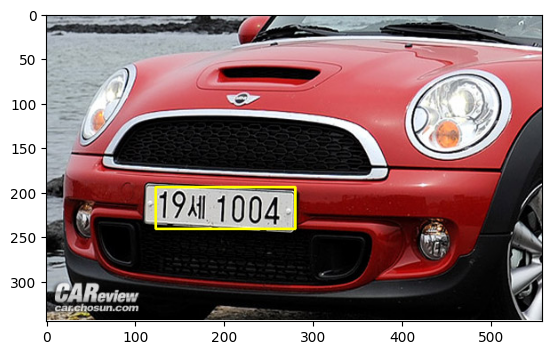

In [11]:
info = plate_infos[longest_idx]
img_out = image.copy()

cv2.rectangle(img_out, (info['x'], info['y']), (info['x'] + info['w'], info['y'] + info['h']), 
              (255,255,0), thickness=2)

plt.imshow(img_out)
plt.show()